In [4]:
import os
from langchain_openai import AzureOpenAIEmbeddings
from dotenv import load_dotenv

load_dotenv()
embeddings = AzureOpenAIEmbeddings(
openai_api_type="azure",
openai_api_version=os.environ["OPENAI_API_EMBEDDING_VERSION"],
openai_api_key=os.environ["OPENAI_API_EMBEDDING_KEY"],
azure_endpoint=os.environ["AZURE_OPENAI_EMBEDDING_ENDPOINT"],
deployment=os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT"],
model=os.environ["AZURE_OPENAI_EMBEDDING_MODEL"],
validate_base_url=True,
)

In [ ]:
# SKIP this only for local loading
from langchain_neo4j import Neo4jVector

url = "bolt://localhost:7687"
username = "neo4j"
password = "password"


vector_store = Neo4jVector.from_existing_index(
    embeddings,
    url=url,
    username=username,
    password=password,
    index_name="neo4j"
)

In [5]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone,ServerlessSpec
import time

pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))
vector_store = PineconeVectorStore(index=pc.Index("langstuffindex"), embedding=embeddings)

In [6]:
import logging
# Set up the logger
logging.basicConfig(
    level=logging.INFO,  # Set to DEBUG for detailed logs
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        # logging.FileHandler("scraper.log"),  # Log to a file
        logging.StreamHandler()  # Log to console
    ]
)

logger = logging.getLogger(__name__)

In [7]:
# TODO first subagent to create from https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/

# TODO critical thinking to allow for model suggestions

from pydantic import Field, BaseModel
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from typing import List
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import PromptTemplate
from langchain.tools.retriever import create_retriever_tool
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from langchain_openai import ChatOpenAI


template = """Your job is to get information from a user about what kind of agent they wish to build.

You should get the following information from them:

- What the objective of the agent is
- Various responsibilities of the agent 
- What model provider to use

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the tool AgentInstruction """

class AgentInstructions(BaseModel):
    """Instructions on how to build the Agent"""
    objective: str = Field(description= "What is the primary objective of the agent")
    responsibilities: List[str] = Field(description= "What are the various responsibilities of the agent which it needs to fulfill")
    model_provider : str = Field(description= "Which model provider powers the LLM workload? eg. OpenAI/Claude/CodeLLama etc.")


class RequirementAnalysisState(MessagesState):
    agent_instructions: AgentInstructions = Field("the requirement analysis generated by the model.")


llm = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

def info_chain(state: RequirementAnalysisState):
    
    llm_with_tool = llm.bind_tools([AgentInstructions])
    response = llm_with_tool.invoke([SystemMessage(content=template)] + state["messages"])
    
      # Construct the final answer from the arguments of the last tool call  
    if len(response.tool_calls) == 0:
        return {"messages": [response]}
    
    agent_instructions = response.tool_calls[0]
    agent_instructions = AgentInstructions(**agent_instructions["args"])
    
    return {"messages": [response], "agent_instructions": agent_instructions}


MODEL_PROMPT = PromptTemplate.from_template(
    """You are a system that generates a graph structure for a multi-agent architecture based on the requirements provided by the user.
You will be provided with the following information:
<objectives>
{objective}
</objectives>

<responsibilities>
{responsibilities}
</responsibilities>

<model_provider>
{model_provider}
</model_provider>

Information about general multi-agent architectures for subagents and their boilerplate code could be found from the retrieval_tool

Once you get information from the retrieval_tool, ponder upon the information, choose the best design which would fit the provided information.
The response should be in this format:

***Agent architecture***

*** description of the agent architecture ***

***justification for the agent architecture***

**tailored code for this scenario to implement the agent architecture**
"""
)

retriever = vector_store.as_retriever()

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_tool",
    "Information about langgraph implementations, Langchain, prompting guide, MCP, agent architectures and other related concepts",
)

tools = [retriever_tool]
def requirment_gen_chain(state: RequirementAnalysisState):
    requirements: AgentInstructions = state["agent_instructions"]
    objective: str = requirements.objective
    responsibilities: List[str] =  requirements.responsibilities
    model_provider : str = requirements.model_provider

    llm_with_tools= llm.bind_tools(tools)
    response = llm_with_tools.invoke([SystemMessage(MODEL_PROMPT.format(objective=objective, responsibilities="\n".join(responsibilities), model_provider= model_provider))] + state["messages"])
    return {"messages": [response]}

def route_state(state: RequirementAnalysisState):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"



memory = MemorySaver()
workflow = StateGraph(RequirementAnalysisState)
workflow.add_node("info", info_chain)
workflow.add_node("requirement_gen", requirment_gen_chain)
workflow.add_node("tools", ToolNode(tools))

@workflow.add_node
def add_tool_message(state: RequirementAnalysisState):
    
   
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }


workflow.add_conditional_edges("info", route_state, ["add_tool_message", "info", END])
workflow.add_edge("add_tool_message", "requirement_gen")
workflow.add_conditional_edges("requirement_gen", tools_condition)
workflow.add_edge("tools", "requirement_gen")
workflow.add_edge(START, "info")
infograph = workflow.compile(checkpointer=memory)

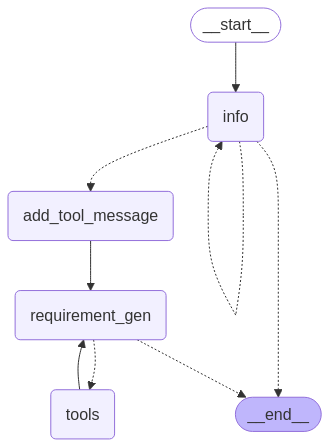

In [8]:
from IPython.display import Image, display
display(Image(infograph.get_graph().draw_mermaid_png()))


In [ ]:
I wish to build a nutritional LLM agent which tracks user goals, allows logging via natural language, provide nutritional and exercise guidance

 1. lose weight, gain muscle. 2. suggest recipes, provide guidance, track meals, allow meal logging. 3. OpenAi

In [9]:
import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in infograph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")
        

User (q/Q to quit): I wish to build a dri agent


2025-04-06 14:54:28,627 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Could you please clarify what the objective of the DRI agent is? Additionally, what responsibilities do you envision for this agent, and which model provider would you like to use?
User (q/Q to quit): 


2025-04-06 14:55:22,793 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

It seems like your message might have been cut off. Could you please provide the objective of the DRI agent, its responsibilities, and the model provider you wish to use?
User (q/Q to quit): The DRI agent will examine the eventguid it is presented relating to an API call, it will fetch the logs and analyze using troubleshooting guides using RAG


2025-04-06 14:58:13,574 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Thank you for the information! To proceed, could you please specify the various responsibilities of the DRI agent? Additionally, which model provider would you like to use for this agent?
User (q/Q to quit): responsibilities are to troubleshoor the issue, perform mitigation, or transfer to the right team. Use OpenAI


2025-04-06 14:58:58,709 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  AgentInstructions (call_LYEZOk0BeiMK1fN4jo06yrK7)
 Call ID: call_LYEZOk0BeiMK1fN4jo06yrK7
  Args:
    objective: Examine the eventguid related to an API call, fetch logs, and analyze using troubleshooting guides with RAG.
    responsibilities: ['Troubleshoot the issue', 'Perform mitigation', 'Transfer to the right team']
    model_provider: OpenAI
================================= Tool Message =================================

Prompt generated!


2025-04-06 14:59:00,362 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  retrieve_tool (call_S9GcIYBmysWqgJCxKnxFUS5L)
 Call ID: call_S9GcIYBmysWqgJCxKnxFUS5L
  Args:
    query: multi-agent architecture for troubleshooting API calls and log analysis


2025-04-06 14:59:02,577 - INFO - HTTP Request: POST https://kanis-m8htxgs7-eastus.openai.azure.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2023-05-15 "HTTP/1.1 200 OK"


================================= Tool Message =================================
Name: retrieve_tool

![multi_agent

Agents

# Agents

In this section, we provide an overview of language agents, including
definitions, common design patterns, tips, and applications.

[Graph Prompting](/techniques/graph "Graph Prompting")[Introduction to
Agents](/agents/introduction "Introduction to Agents")

[ ](https://github.com/langchain-
ai/langgraph/edit/main/docs/docs/tutorials/multi_agent/multi-agent-
collaboration.ipynb "Edit this page")

# Multi-agent network¶

A single agent can usually operate effectively using a handful of tools within
a single domain, but even using powerful models like `gpt-4`, it can be less
effective at using many tools.

One way to approach complicated tasks is through a "divide-and-conquer"
approach: create a specialized agent for each task or domain and route tasks
to the correct "expert". This is an example of a [multi-agent
network](https://langchain-
ai.github.io/l

2025-04-06 14:59:07,533 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

***Agent architecture***

The proposed architecture for the DRI agent is a **multi-agent network**. This architecture consists of specialized agents that handle different aspects of the troubleshooting process, allowing for a more efficient and organized approach to resolving API call issues.

***Description of the agent architecture***

1. **Event Examination Agent**: This agent is responsible for examining the `eventguid` related to the API call. It retrieves relevant information and prepares it for further analysis.
  
2. **Log Fetching Agent**: This agent fetches logs associated with the API call. It communicates with the Event Examination Agent to receive the necessary context and parameters for fetching the logs.

3. **Troubleshooting Agent**: This agent analyzes the logs using predefined troubleshooting guides and RAG (Retrieval-Augmented Generation) techniques. It identifies potential issues and s

# EXAMPLE DRI AGENT


***Agent architecture***

The proposed architecture for the DRI agent is a **multi-agent network**. This architecture consists of specialized agents that handle different aspects of the troubleshooting process, allowing for a more efficient and organized approach to resolving API call issues.

***Description of the agent architecture***

1. **Event Examination Agent**: This agent is responsible for examining the `eventguid` related to the API call. It retrieves relevant information and prepares it for further analysis.
  
2. **Log Fetching Agent**: This agent fetches logs associated with the API call. It communicates with the Event Examination Agent to receive the necessary context and parameters for fetching the logs.

3. **Troubleshooting Agent**: This agent analyzes the logs using predefined troubleshooting guides and RAG (Retrieval-Augmented Generation) techniques. It identifies potential issues and suggests solutions.

4. **Mitigation Agent**: Once the troubleshooting agent identifies an issue, this agent performs mitigation actions based on the recommendations provided.

5. **Transfer Agent**: If the issue cannot be resolved, this agent is responsible for transferring the case to the appropriate team for further investigation.

The agents communicate through a shared state, allowing them to pass information seamlessly throughout the troubleshooting process.

***Justification for the agent architecture***

The multi-agent network architecture is ideal for this scenario because it allows for a clear division of responsibilities among specialized agents. Each agent can focus on a specific task, leading to improved efficiency and effectiveness in troubleshooting API call issues. This architecture also supports dynamic control flow, enabling agents to make decisions based on the context of the situation, which is crucial for effective problem resolution.

**Tailored code for this scenario to implement the agent architecture**


In [ ]:

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START

model = ChatOpenAI()

def event_examination_agent(state: MessagesState):
    event_guid = state.get("event_guid")
    # Logic to examine the event_guid
    response = model.invoke(f"Examine the event GUID: {event_guid}")
    return {"messages": [response], "logs_fetched": True}

def log_fetching_agent(state: MessagesState):
    if not state.get("logs_fetched"):
        return {"messages": ["Logs not fetched yet."]}
    # Logic to fetch logs
    response = model.invoke("Fetch logs for the API call.")
    return {"messages": [response], "logs": True}

def troubleshooting_agent(state: MessagesState):
    if not state.get("logs"):
        return {"messages": ["Logs not available for analysis."]}
    # Logic to analyze logs using troubleshooting guides
    response = model.invoke("Analyze the logs using troubleshooting guides.")
    return {"messages": [response], "issue_identified": True}

def mitigation_agent(state: MessagesState):
    if not state.get("issue_identified"):
        return {"messages": ["No issue identified to mitigate."]}
    # Logic to perform mitigation
    response = model.invoke("Perform mitigation actions.")
    return {"messages": [response]}

def transfer_agent(state: MessagesState):
    if state.get("issue_identified"):
        return {"messages": ["Issue resolved. No transfer needed."]}
    # Logic to transfer to the right team
    response = model.invoke("Transfer to the appropriate team.")
    return {"messages": [response]}

builder = StateGraph(MessagesState)
builder.add_node(event_examination_agent)
builder.add_node(log_fetching_agent)
builder.add_node(troubleshooting_agent)
builder.add_node(mitigation_agent)
builder.add_node(transfer_agent)

# Define the flow explicitly
builder.add_edge(START, "event_examination_agent")
builder.add_edge("event_examination_agent", "log_fetching_agent")
builder.add_edge("log_fetching_agent", "troubleshooting_agent")
builder.add_edge("troubleshooting_agent", "mitigation_agent")
builder.add_edge("troubleshooting_agent", "transfer_agent")

# Generated code for nutritional LLM agent

**Agent architecture***

The proposed architecture for your nutritional LLM agent is a **Supervisor (tool-calling)** architecture. In this design, individual agents are defined as tools, and a supervisor agent (powered by an LLM) decides which tool (agent) to call based on user input and the current state of the conversation.

***Justification for the agent architecture***

1. **Modularity**: Each responsibility (suggesting recipes, providing guidance, tracking meals, allowing meal logging) can be encapsulated in separate agents. This modularity allows for easier development, testing, and maintenance.

2. **Dynamic Control**: The supervisor agent can dynamically decide which tool to call next based on the user's input and the context of the conversation. This flexibility is essential for handling the varied and complex nature of nutritional guidance.

3. **Specialization**: Each agent can specialize in a specific task, improving the overall performance of the system. For example, one agent can focus solely on recipe suggestions, while another can handle meal tracking.

4. **Natural Language Interaction**: The architecture allows for natural language logging and interaction, making it user-friendly and accessible.

**Tailored code for this scenario to implement the agent architecture**

This is the code piece referred to from memory and llm tailored it

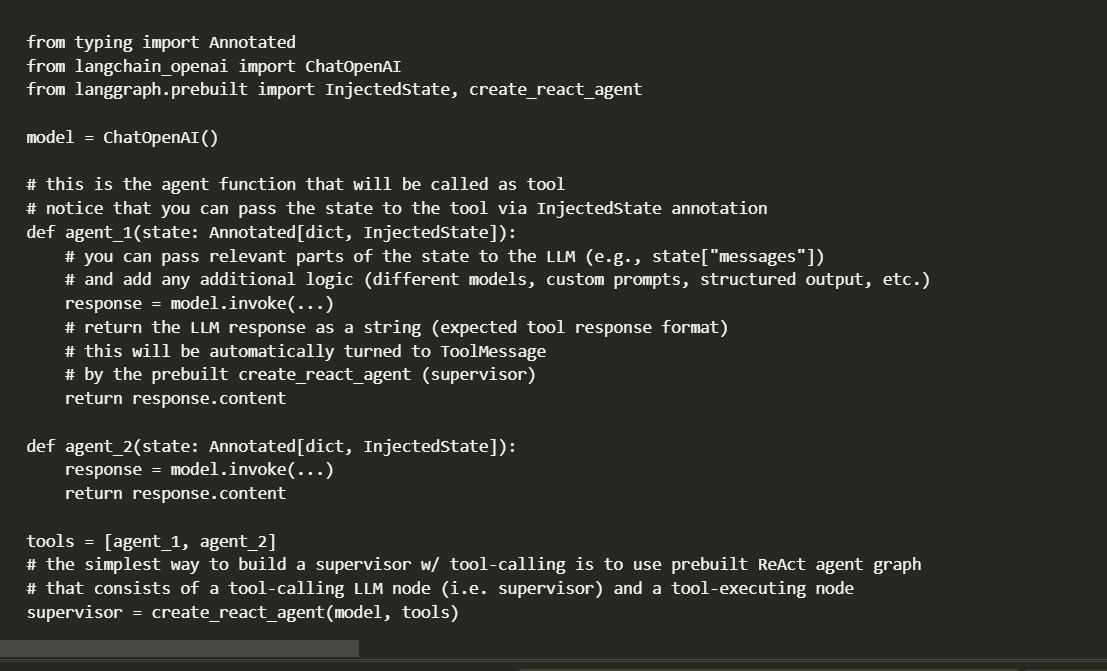

In [2]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import InjectedState, create_react_agent

# Initialize the OpenAI model
model = ChatOpenAI()

# Define the agent for suggesting recipes
def suggest_recipes(state: Annotated[dict, InjectedState]):
    """suggest recipes

    Args:
        state (Annotated[dict, InjectedState]): _description_

    Returns:
        _type_: _description_
    """
    # Logic to suggest recipes based on user preferences
    response = model.invoke("Suggest a healthy recipe for weight loss and muscle gain.")
    return response.content

# Define the agent for providing guidance
def provide_guidance(state: Annotated[dict, InjectedState]):
    """ provide nutritional guidance to the user
    Args:
        state (Annotated[dict, InjectedState]): _description_

    Returns:
        _type_: _description_
    """
    # Logic to provide nutritional and exercise guidance
    response = model.invoke("Provide guidance on nutrition and exercise for weight loss and muscle gain.")
    return response.content

# Define the agent for tracking meals
def track_meals(state: Annotated[dict, InjectedState]):
    """ track meals for the user

    Args:
        state (Annotated[dict, InjectedState]): _description_

    Returns:
        _type_: _description_
    """
    # Logic to track meals
    response = model.invoke("Track my meals for today.")
    return response.content

# Define the agent for allowing meal logging
def log_meal(state: Annotated[dict, InjectedState]):
    """log meals for the user

    Args:
        state (Annotated[dict, InjectedState]): _description_

    Returns:
        _type_: _description_
    """
    # Logic to log meals
    response = model.invoke("Log my meal: [meal details].")
    return response.content

# List of agents (tools)
tools = [suggest_recipes, provide_guidance, track_meals, log_meal]

# Create the supervisor agent using the tool-calling architecture
supervisor = create_react_agent(model, tools)